<a href="https://colab.research.google.com/github/jm5159/E4511-2021-Mao/blob/master/Delaney_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Predicting Solubility Using AMPL</h1>

The ATOM Modeling PipeLine (AMPL; https://github.com/ATOMconsortium/AMPL) is an open-source, modular, extensible software pipeline for building and sharing models to advance in silico drug discovery.

**Warning: This is an experimental notebook**

# Goal: Predict solubility using the ATOM Modeling Pipeline (AMPL) on the public dataset

In this notebook, we describe the following steps using AMPL:

1.   Read a public dataset containing chemical structures and some properties
1.   Curate the dataset 
2.   Fit a simple model
3.   Predict solubility for withheld compounds


## Set up
We first import the AMPL modules for use in this notebook.

The relevant AMPL modules for this example are listed below:

|module|Description|
|-|-|
|`atomsci.ddm.pipeline.model_pipeline`|The model pipeline module is used to fit models and load models for prediction.|
|`atomsci.ddm.pipeline.parameter_parser`|The parameter parser reads through pipeline options for the model pipeline.|
|`atomsci.ddm.utils.curate_data`|The curate data module is used for data loading and pre-processing.|
|`atomsci.ddm.utils.struct_utils`|The structure utilities module is used to process loaded structures.|
|`atomsci.ddm.pipeline.perf_plots`|Perf plots contains a variety of plotting functions.|

## Install AMPL

In [2]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-03-25 17:29:08--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.


real	0m16.119s
user	0m14.880s
sys	0m1.268s
--2021-03-25 17:31:34--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|1

In [44]:
# Load AMPL in this notebook

site_packages_path = '/content/AMPL/lib/python3.7/site-packages'
if site_packages_path not in sys.path:
  sys.path.insert(1, site_packages_path)
sys.path

['/tensorflow-1.15.2/python3.7',
 '/content/AMPL/lib/python3.7/site-packages',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/local/lib/python3.7/site-packages/']

In [45]:
# There is a problem with the previously imported cffi, so delete it and 
# load it with AMPL instead
if 'cffi' in sys.modules:
  del sys.modules['cffi']

In [46]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import os
import requests
import sys

import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp


## Data curation

We then download and do very simple curation to the related dataset.

We need to set the directory we want to save files to. Next we download the dataset.

In [47]:
working_dir = '/content'

In [48]:
import io
url = 'https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/CYP3A4_cur.csv'
download = requests.get(url).content

In [49]:
# Reading the downloaded content and turning it into a pandas dataframe
raw_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

In [ ]:
# copy of processed delaney data from AMPL
# r = requests.get('https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/delaney-processed_curated_external.csv', verify=True)

Next, we load the downloaded dataset, and process the compound structures:

In [50]:
data_orig = raw_df

In [51]:
raw_df.columns

Index(['Unnamed: 0', 'compound_id', 'base_rdkit_smiles', 'relation', 'pXC50',
       'active'],
      dtype='object')

In [52]:
raw_df.head(5)

,Unnamed: 0,compound_id,base_rdkit_smiles,relation,pXC50,active
0,0,CHEMBL1537880,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,NaN,5.300000,0
1,1,CHEMBL1515033,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,NaN,5.100000,0
2,2,CHEMBL3422242,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,<,4.522879,0
3,3,CHEMBL1526043,N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1,NaN,4.400000,0
4,4,CHEMBL3145019,Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1,NaN,4.800000,0


In [53]:
# base_smiles_from_smiles:
# Generate a standardized SMILES, InChI keys for dataset with curation and structure modules.
# RDkit modules are used to process the SMILES strings

# Default Arg options: 
# useIsomericSmiles = True
# removeCharges = False 

raw_df['rdkit_smiles'] = raw_df['base_rdkit_smiles'].apply(curate_data.base_smiles_from_smiles)

In [54]:
raw_df['inchi_key'] = raw_df['rdkit_smiles'].apply(struct_utils.smiles_to_inchi_key)

In [55]:
raw_df.head(3)

,Unnamed: 0,compound_id,base_rdkit_smiles,relation,pXC50,active,rdkit_smiles,inchi_key
0,0,CHEMBL1537880,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,NaN,5.300000,0,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,WNUWUYIZADTROQ-UHFFFAOYSA-N
1,1,CHEMBL1515033,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,NaN,5.100000,0,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,LFQJIVPPRFXMAC-AWEZNQCLSA-N
2,2,CHEMBL3422242,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,<,4.522879,0,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,HVEVDFRWOQHAPJ-CKMNQQOVSA-N


In [56]:
data = raw_df
data['Compound_ID'] = data['inchi_key']

## Let us review the dataset

In [57]:
data.head(3)

,Unnamed: 0,compound_id,base_rdkit_smiles,relation,pXC50,active,rdkit_smiles,inchi_key,Compound_ID
0,0,CHEMBL1537880,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,NaN,5.300000,0,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,WNUWUYIZADTROQ-UHFFFAOYSA-N,WNUWUYIZADTROQ-UHFFFAOYSA-N
1,1,CHEMBL1515033,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,NaN,5.100000,0,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,LFQJIVPPRFXMAC-AWEZNQCLSA-N,LFQJIVPPRFXMAC-AWEZNQCLSA-N
2,2,CHEMBL3422242,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,<,4.522879,0,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,HVEVDFRWOQHAPJ-CKMNQQOVSA-N,HVEVDFRWOQHAPJ-CKMNQQOVSA-N


## Let us view some molecules

In [58]:
data['base_rdkit_smiles'][0:10]

0              Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1
1             CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1
2    Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...
3      N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1
4                   Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1
5    COc1cccc(-c2c(C)n(Cc3c(F)cccc3C(F)(F)F)c(=O)n(...
6                 CN(C)CCN1CCCc2cc(N=C(N)c3cccs3)ccc21
7                  N/C(=N/CCc1ccc(I)cc1)SCCCc1cnc[nH]1
8    Cc1ccc(S(=O)(=O)N2CCOCC2)cc1NC(=O)COC(=O)CCC(=...
9    COc1cccc(N2C(=O)N(Cc3ccccc3F)C3(CCN(Cc4ccc(-c5...
Name: base_rdkit_smiles, dtype: object

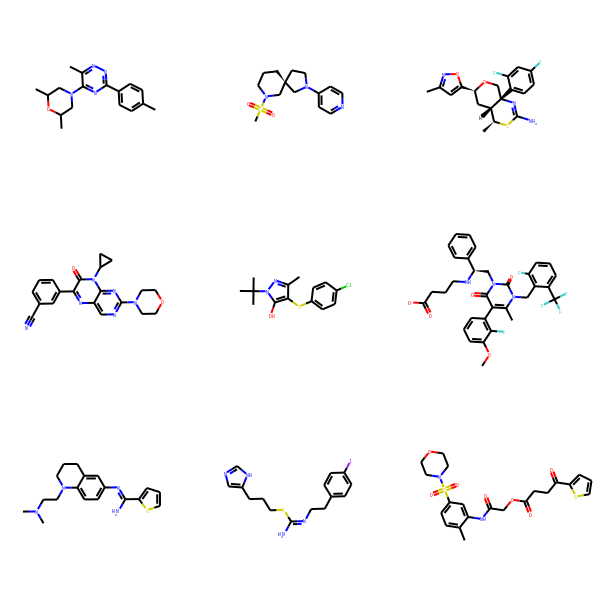

In [59]:
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice

molecules = [Chem.MolFromSmiles(smiles) for smiles in islice(data['base_rdkit_smiles'], 9)]

Draw.MolsToGridImage(molecules)

The next step is to address the case where we have multiple measurements for a single structure (by RDkit canonical SMILEs string). We have a function in the `curate_data()` module to address the processing of compounds. The function parameters are listed below along with an explanation of each parameter:

In [60]:
data

,Unnamed: 0,compound_id,base_rdkit_smiles,relation,pXC50,active,rdkit_smiles,inchi_key,Compound_ID
0,0,CHEMBL1537880,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,NaN,5.300000,0,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,WNUWUYIZADTROQ-UHFFFAOYSA-N,WNUWUYIZADTROQ-UHFFFAOYSA-N
1,1,CHEMBL1515033,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,NaN,5.100000,0,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,LFQJIVPPRFXMAC-AWEZNQCLSA-N,LFQJIVPPRFXMAC-AWEZNQCLSA-N
2,2,CHEMBL3422242,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,<,4.522879,0,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,HVEVDFRWOQHAPJ-CKMNQQOVSA-N,HVEVDFRWOQHAPJ-CKMNQQOVSA-N
3,3,CHEMBL1526043,N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1,NaN,4.400000,0,N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1,QIZLBSOCEJVBTG-UHFFFAOYSA-N,QIZLBSOCEJVBTG-UHFFFAOYSA-N
4,4,CHEMBL3145019,Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1,NaN,4.800000,0,Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1,IYIGLQSFYOLXCS-UHFFFAOYSA-N,IYIGLQSFYOLXCS-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...
19631,19631,CHEMBL3932169,CC(C)[C@@H]1c2nn(-c3cccc(S(C)(=O)=O)c3)cc2CN1c...,NaN,5.515700,0,CC(C)[C@@H]1c2nn(-c3cccc(S(C)(=O)=O)c3)cc2CN1c...,NCZXBZJVJRJUSC-GOSISDBHSA-N,NCZXBZJVJRJUSC-GOSISDBHSA-N
19632,19632,CHEMBL4210866,N[C@@H]1CCC=C(c2ccc(F)cc2)[C@H]1CNc1cc(F)c(S(=...,NaN,4.481486,0,N[C@@H]1CCC=C(c2ccc(F)cc2)[C@H]1CNc1cc(F)c(S(=...,BSNVRJYSKXDALK-VQIMIIECSA-N,BSNVRJYSKXDALK-VQIMIIECSA-N
19633,19633,CHEMBL1465534,O=[N+]([O-])c1cccc(-c2nnn(C34CC5CC(CC(C5)C3)C4...,NaN,5.050000,0,O=[N+]([O-])c1cccc(-c2nnn(C34CC5CC(CC(C5)C3)C4...,ILMKPNZNEYHDGO-UHFFFAOYSA-N,ILMKPNZNEYHDGO-UHFFFAOYSA-N
19634,19634,CHEMBL3237445,Cc1nccc2c3cnc(Nc4ccc(N5CCNCC5)cn4)nc3n(C3CCCC3...,<,5.000000,0,Cc1nccc2c3cnc(Nc4ccc(N5CCNCC5)cn4)nc3n(C3CCCC3...,FLNHSHVOGZEONH-UHFFFAOYSA-N,FLNHSHVOGZEONH-UHFFFAOYSA-N


In [ ]:
# del_features = ['VALUE_NUM_mean', 'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate']
# data.drop(labels=del_features, axis=1, inplace=True)

In [61]:
# column: Response values column
column = 'pXC50'

# tolerance: Percentage of individual respsonse values allowed to be different 
# from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'Compound_ID'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# call the method `average_and_remove_duplicates` which changes the data and returns
# the new object as curated_df, in this case
 

curated_df = curate_data.average_and_remove_duplicates(column, 
                                                       tolerance, 
                                                       list_bad_duplicates, 
                                                       data, 
                                                       max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (19636, 13)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [Compound_ID, pXC50, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (19636, 13)
New column created with averaged values:  VALUE_NUM_mean


In [62]:
data.head(3)

,Unnamed: 0,compound_id,base_rdkit_smiles,relation,pXC50,active,rdkit_smiles,inchi_key,Compound_ID
0,0,CHEMBL1537880,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,NaN,5.300000,0,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,WNUWUYIZADTROQ-UHFFFAOYSA-N,WNUWUYIZADTROQ-UHFFFAOYSA-N
1,1,CHEMBL1515033,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,NaN,5.100000,0,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,LFQJIVPPRFXMAC-AWEZNQCLSA-N,LFQJIVPPRFXMAC-AWEZNQCLSA-N
2,2,CHEMBL3422242,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,<,4.522879,0,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,HVEVDFRWOQHAPJ-CKMNQQOVSA-N,HVEVDFRWOQHAPJ-CKMNQQOVSA-N


In [63]:
curated_df.head(3)

,Unnamed: 0,compound_id,base_rdkit_smiles,relation,pXC50,active,rdkit_smiles,inchi_key,Compound_ID,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,0,CHEMBL1537880,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,NaN,5.300000,0,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,WNUWUYIZADTROQ-UHFFFAOYSA-N,WNUWUYIZADTROQ-UHFFFAOYSA-N,5.300000,NaN,0.0,0
1,1,CHEMBL1515033,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,NaN,5.100000,0,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,LFQJIVPPRFXMAC-AWEZNQCLSA-N,LFQJIVPPRFXMAC-AWEZNQCLSA-N,5.100000,NaN,0.0,0
2,2,CHEMBL3422242,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,<,4.522879,0,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,HVEVDFRWOQHAPJ-CKMNQQOVSA-N,HVEVDFRWOQHAPJ-CKMNQQOVSA-N,4.522879,NaN,0.0,0


In [66]:
curated_df.groupby(['rdkit_smiles'])['rdkit_smiles'].count()

rdkit_smiles
Br/C(=N\Nc1nn[nH]n1)c1ccncc1                               1
Brc1c(Br)c(Br)c2n[nH]nc2c1Br                               1
Brc1c(NC2=NCCN2)ccc2nccnc12                                1
Brc1cc2c(cc1/C=N/Nc1nc(N3CCCC3)nc(N3CCOCC3)n1)OCO2         1
Brc1ccc(-n2c(SCc3ccccc3)nnc2-c2ccncc2)cc1                  1
                                                          ..
c1nc(NCCN2CCOCC2)c2cc(-c3ccoc3)ccc2n1                      1
c1nc(NCCc2cnc[nH]2)c2[nH]cnc2n1                            1
c1nc(N[C@H]2CC[C@H](N3CCOCC3)CC2)c2c(C3CCOCC3)c[nH]c2n1    1
c1ncc(-c2ccc3c(c2)OCO3)c(NCCc2cnc[nH]2)n1                  1
c1ncc(-c2ccoc2)c(NC2CC2)n1                                 1
Name: rdkit_smiles, Length: 18981, dtype: int64

In [65]:
curated_df = curated_df.drop_duplicates(subset='Compound_ID', keep="first")

In [67]:
curated_file = os.path.join(working_dir, 'delaney_curated.csv')
curated_df.to_csv(curated_file, index=False)


featurizer = 'ecfp'
model_type = 'RF'
response_cols = ['VALUE_NUM_mean']

Now that we have a curated dataset, we decide what type of featurizer and model we would like. See documentation for all available options. We also set the name of the new averaged response value column.

In [68]:
featurizer = 'ecfp'
model_type = 'RF'
response_cols = ['VALUE_NUM_mean']

Next we set up the parameters for our model. We set datastore and save_results to False to indicate that we are reading the input file and saving the results directly to the file system. There are a wide range of settable parameters; see the documentation for more details.

In [69]:
smiles_col

'rdkit_smiles'

In [70]:
params={"datastore": "False",
        "save_results": "False",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_cols,
        "featurizer": featurizer,
        "model_type": model_type,
        "result_dir": working_dir,
        "dataset_key": curated_file}

We use parse.wrapper to process our input configuration. We then build the model pipeline, train the model, and plot the predicted versus true values for our train, valid, test sets.

In [71]:
pparams = parse.wrapper(params)

## Details of the following code chunk
 Here we create instances of the class ModelPipeline, called `MP`. The instance `MP` has access to data attributes and methods of the class. 

In [72]:
MP = mp.ModelPipeline(pparams)

## Use `dir` function to explore data attributes and functions associated with the class. 

The output is a list of data object attributes. Note the attributes that are surrounded by double-underscore (ex., `__le__`) are for internal use
and you dont have to worry about them. The regular (non underscore attributes) are of your concern. In the example shown below, these attributes start
with `'create_model_metadata'`

In [73]:
dir(MP)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'create_model_metadata',
 'create_prediction_metadata',
 'ds_client',
 'get_metrics',
 'load_featurize_data',
 'log',
 'metric_type',
 'output_dir',
 'params',
 'perf_dict',
 'predict_full_dataset',
 'predict_on_dataframe',
 'predict_on_smiles',
 'run_mode',
 'run_predictions',
 'save_metrics',
 'save_model_metadata',
 'split_dataset',
 'start_time',
 'train_model']

### Train_model:
Build model described by self.params on the training dataset described by self.params.Generate predictions for the training, validation, and test datasets, and save the predictions and performance metrics in the model results DB or in a JSON file.

## Note `train_model` is a method of class `ModelPipeline`. If you are using COLAB, mouse-over the `MP.train_model()` to view the source code

number of features: 1024


2021-03-25 18:58:22,539 Splitting data by scaffold
2021-03-25 18:58:35,804 Dataset split table saved to /content/delaney_curated_train_valid_test_scaffold_de29b8fe-3a8f-46d5-9d65-340cd8789e58.csv


n_cnt [18981.]
y_means [5.19079437]
y_stds [1.2065302]
TIMING: dataset construction took 0.717 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.


2021-03-25 18:59:18,410 Wrote model metadata to file /content/delaney_curated/RF_ecfp_scaffold_regression/b31d00a9-daed-45d4-9716-530f5203658d/model_metadata.json
2021-03-25 18:59:23,692 Wrote model metrics to file /content/delaney_curated/RF_ecfp_scaffold_regression/b31d00a9-daed-45d4-9716-530f5203658d/model_metrics.json


Wrote model tarball to /content/delaney_curated_model_b31d00a9-daed-45d4-9716-530f5203658d.tar.gz


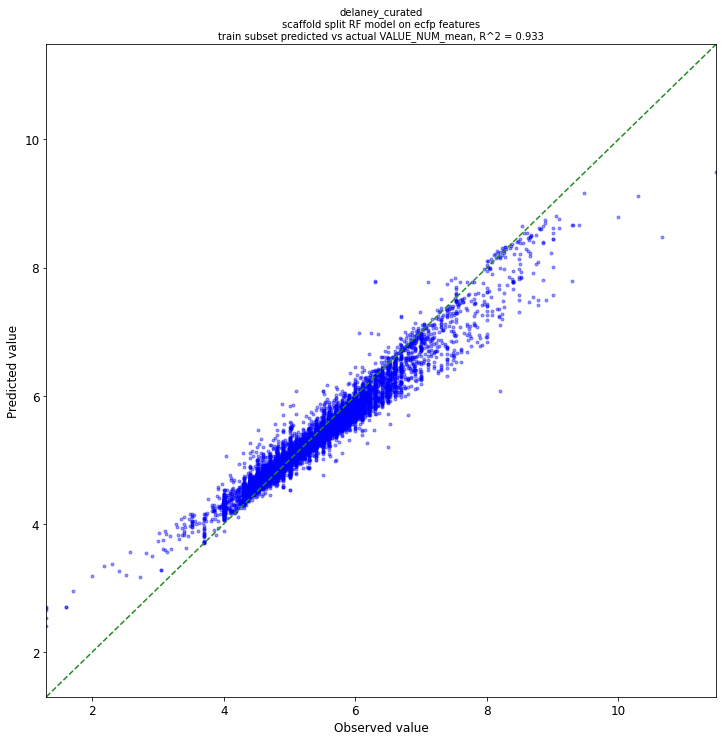

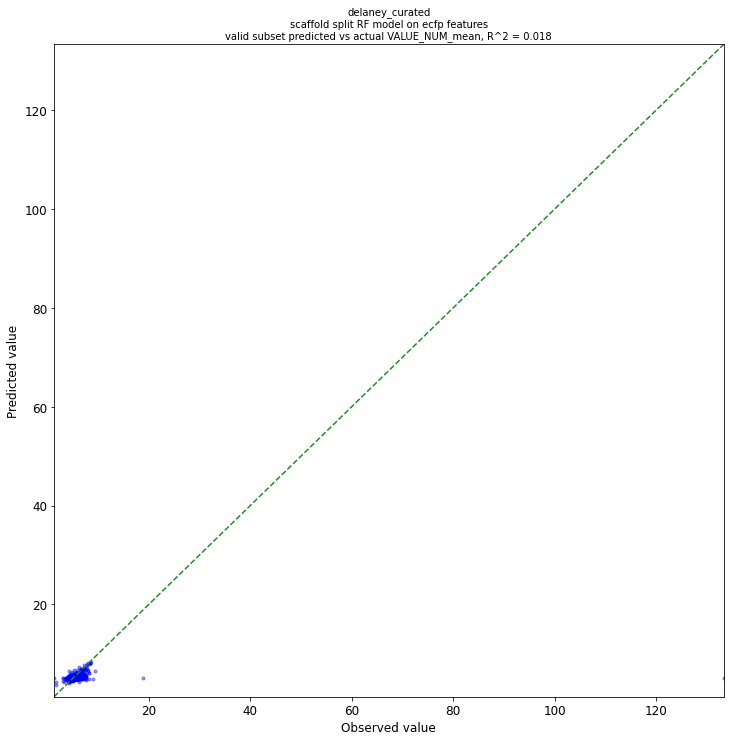

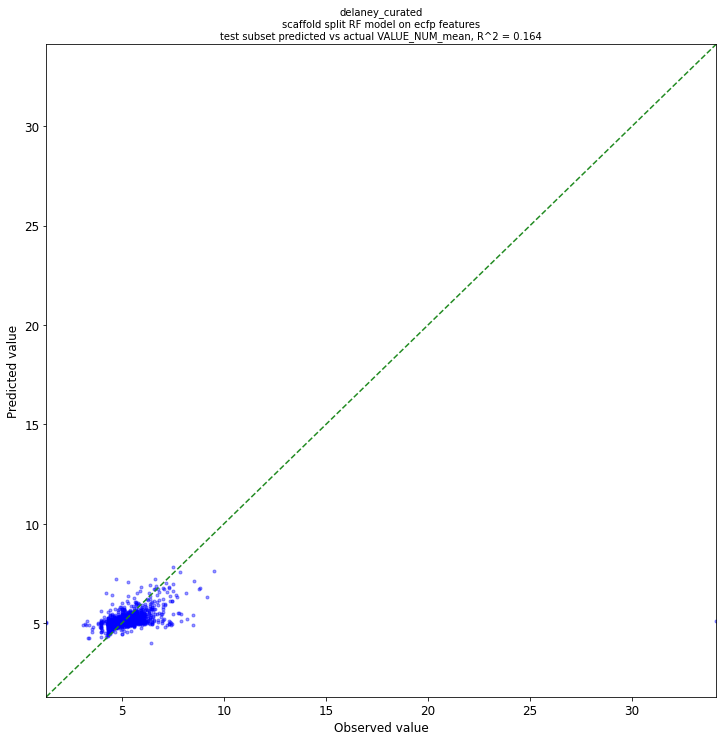

In [74]:
MP.train_model()

pp.plot_pred_vs_actual(MP)

In [43]:
pparams
# MP.train_model()

Namespace(autoencoder_bucket=None, autoencoder_key=None, autoencoder_type='molvae', base_splitter='scaffold', baseline_epoch=30, batch_size=50, bias_init_consts=None, bucket='public', butina_cutoff=0.18, class_name=None, class_number=2, collection_name='model_tracker', config_file=None, cutoff_date=None, data_owner='gsk', data_owner_group='gsk_craa', dataset_key='/content/delaney_curated.csv', dataset_name='delaney_curated', dataset_oid=None, datastore=False, date_col=None, descriptor_bucket='public', descriptor_key=None, descriptor_oid=None, descriptor_spec_bucket='', descriptor_spec_key='/usr/local/lib/python3.7/site-packages/atomsci/ddm/data/descriptor_sets_sources_by_descr_type.csv', descriptor_type='moe', dp=None, dropout_list=None, dropouts=None, ecfp_radius=2, ecfp_size=1024, feature_transform_type='normalization', featurizer='ecfp', hyperparam=False, hyperparam_uuid=None, id_col='Compound_ID', layer_nums=None, layer_sizes=None, lc_account='baasic', learning_rate=0.0005, lr=None

In [ ]:
!date

Tue Mar 16 15:02:06 UTC 2021
